In [1]:
#Import the necessary libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
print(device)

cuda


In [3]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset
train_loader, valid_loader = get_train_valid_loader(data_dir = './data',                                      batch_size = 64,
                       augment = False,                             		     random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                              batch_size = 64)

100%|██████████| 170498071/170498071 [00:01<00:00, 102406598.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [4]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [13]:
num_classes = 10
num_epochs = 5 #Do to lack to time i am running it on 5 epochs only as I have to run it on multiple changes and Resnet as well
batch_size = 64
learning_rate = 0.005
# In regularized scenario I will take lr as 0.005 and then 0.010 and plot for both to see the changes.
model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.000, momentum = 0.9)
# The weight decay decides the L2 regularization here so If I set it to 0.00 then there will be no regularization and if it is 0.001 then the lambda of regularization is set to
# Some non zero value and I will plot for both regularized and unregularized

# Train the model
total_step = len(train_loader)

In [14]:
total_step = len(train_loader)
loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracy_values.append(accuracy)
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, accuracy))


Epoch [1/5], Step [1/704], Loss: 2.2906
Epoch [1/5], Step [2/704], Loss: 2.2599
Epoch [1/5], Step [3/704], Loss: 2.3805
Epoch [1/5], Step [4/704], Loss: 2.3406
Epoch [1/5], Step [5/704], Loss: 2.3132
Epoch [1/5], Step [6/704], Loss: 2.2728
Epoch [1/5], Step [7/704], Loss: 2.3440
Epoch [1/5], Step [8/704], Loss: 2.3091
Epoch [1/5], Step [9/704], Loss: 2.3080
Epoch [1/5], Step [10/704], Loss: 2.2298
Epoch [1/5], Step [11/704], Loss: 2.2501
Epoch [1/5], Step [12/704], Loss: 2.1279
Epoch [1/5], Step [13/704], Loss: 2.1413
Epoch [1/5], Step [14/704], Loss: 2.1216
Epoch [1/5], Step [15/704], Loss: 2.2466
Epoch [1/5], Step [16/704], Loss: 2.0776
Epoch [1/5], Step [17/704], Loss: 2.0823
Epoch [1/5], Step [18/704], Loss: 2.2027
Epoch [1/5], Step [19/704], Loss: 2.1678
Epoch [1/5], Step [20/704], Loss: 2.1627
Epoch [1/5], Step [21/704], Loss: 1.9652
Epoch [1/5], Step [22/704], Loss: 1.8927
Epoch [1/5], Step [23/704], Loss: 1.9310
Epoch [1/5], Step [24/704], Loss: 2.1689
Epoch [1/5], Step [25/704

In [12]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 74.79 %


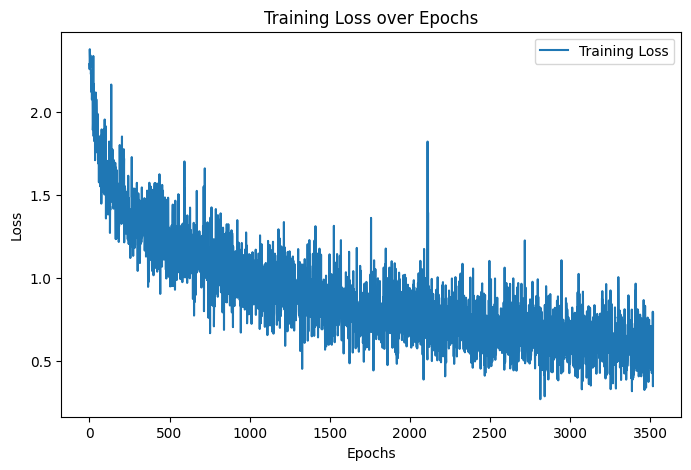

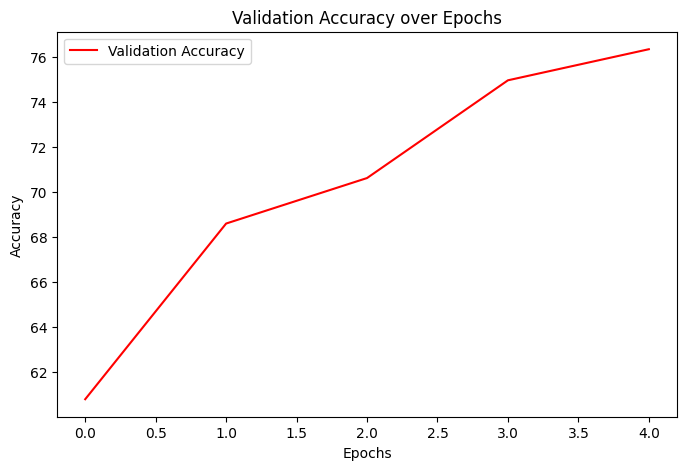

In [15]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(8, 5))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(8, 5))
plt.plot(accuracy_values, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

#This was when there was no regularization

In [5]:
num_classes = 10
num_epochs = 5 #Do to lack to time i am running it on 5 epochs only as I have to run it on multiple changes and Resnet as well
batch_size = 64
learning_rate = 0.005
# In regularized scenario I will take lr as 0.005 and then 0.010 and plot for both to see the changes.
model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)
# The weight decay decides the L2 regularization here so If I set it to 0.00 then there will be no regularization and if it is 0.001 then the lambda of regularization is set to
# Some non zero value and I will plot for both regularized and unregularized

# Train the model
total_step = len(train_loader)

In [6]:
total_step = len(train_loader)
loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracy_values.append(accuracy)
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, accuracy))


Epoch [1/5], Step [1/704], Loss: 2.2915
Epoch [1/5], Step [2/704], Loss: 2.3041
Epoch [1/5], Step [3/704], Loss: 2.2694
Epoch [1/5], Step [4/704], Loss: 2.3229
Epoch [1/5], Step [5/704], Loss: 2.4747
Epoch [1/5], Step [6/704], Loss: 2.3046
Epoch [1/5], Step [7/704], Loss: 2.2638
Epoch [1/5], Step [8/704], Loss: 2.4598
Epoch [1/5], Step [9/704], Loss: 2.2821
Epoch [1/5], Step [10/704], Loss: 2.3306
Epoch [1/5], Step [11/704], Loss: 2.2596
Epoch [1/5], Step [12/704], Loss: 2.1858
Epoch [1/5], Step [13/704], Loss: 2.1825
Epoch [1/5], Step [14/704], Loss: 2.2193
Epoch [1/5], Step [15/704], Loss: 2.1434
Epoch [1/5], Step [16/704], Loss: 2.0436
Epoch [1/5], Step [17/704], Loss: 2.1591
Epoch [1/5], Step [18/704], Loss: 2.0381
Epoch [1/5], Step [19/704], Loss: 2.2146
Epoch [1/5], Step [20/704], Loss: 2.0600
Epoch [1/5], Step [21/704], Loss: 2.2738
Epoch [1/5], Step [22/704], Loss: 2.1033
Epoch [1/5], Step [23/704], Loss: 1.9844
Epoch [1/5], Step [24/704], Loss: 2.0361
Epoch [1/5], Step [25/704

In [7]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 76.89 %


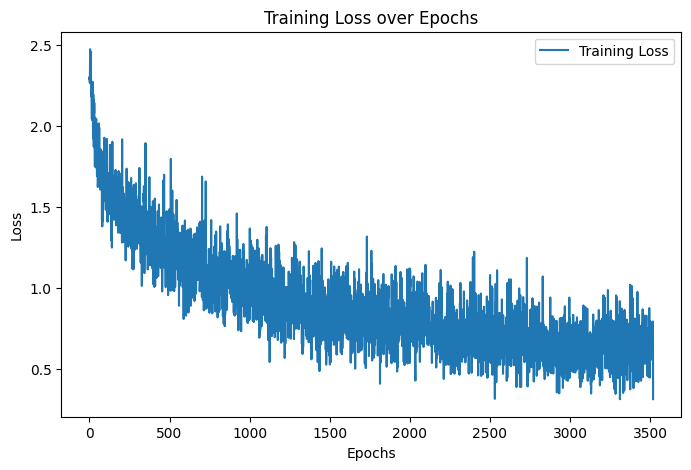

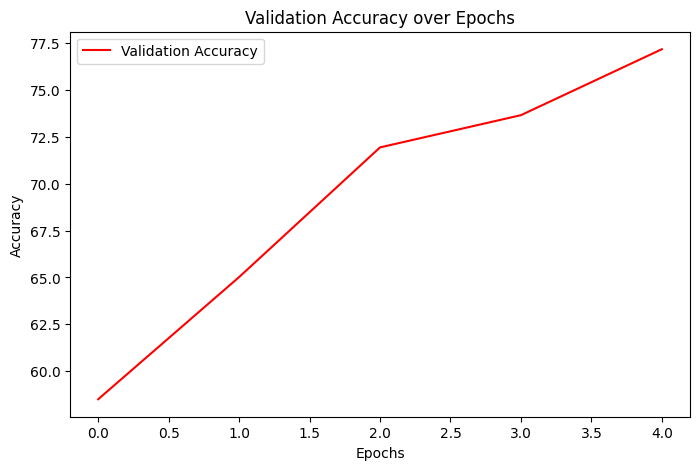

In [8]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(8, 5))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(8, 5))
plt.plot(accuracy_values, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

#This was when there was regularization

In [9]:
num_classes = 10
num_epochs = 5 #Do to lack to time i am running it on 5 epochs only as I have to run it on multiple changes and Resnet as well
batch_size = 64
learning_rate = 0.010
# In regularized scenario I will take lr as 0.005 and then 0.010 and plot for both to see the changes.
model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)
# The weight decay decides the L2 regularization here so If I set it to 0.00 then there will be no regularization and if it is 0.001 then the lambda of regularization is set to
# Some non zero value and I will plot for both regularized and unregularized

# Train the model
total_step = len(train_loader)

In [10]:
total_step = len(train_loader)
loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracy_values.append(accuracy)
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, accuracy))


Epoch [1/5], Step [1/704], Loss: 2.3868
Epoch [1/5], Step [2/704], Loss: 2.3818
Epoch [1/5], Step [3/704], Loss: 2.3647
Epoch [1/5], Step [4/704], Loss: 2.2393
Epoch [1/5], Step [5/704], Loss: 2.3510
Epoch [1/5], Step [6/704], Loss: 2.3961
Epoch [1/5], Step [7/704], Loss: 2.3081
Epoch [1/5], Step [8/704], Loss: 2.3367
Epoch [1/5], Step [9/704], Loss: 2.3407
Epoch [1/5], Step [10/704], Loss: 2.1226
Epoch [1/5], Step [11/704], Loss: 2.3079
Epoch [1/5], Step [12/704], Loss: 2.1620
Epoch [1/5], Step [13/704], Loss: 2.1540
Epoch [1/5], Step [14/704], Loss: 2.3732
Epoch [1/5], Step [15/704], Loss: 2.1063
Epoch [1/5], Step [16/704], Loss: 2.0963
Epoch [1/5], Step [17/704], Loss: 2.1599
Epoch [1/5], Step [18/704], Loss: 2.1189
Epoch [1/5], Step [19/704], Loss: 2.1551
Epoch [1/5], Step [20/704], Loss: 2.1765
Epoch [1/5], Step [21/704], Loss: 1.9224
Epoch [1/5], Step [22/704], Loss: 2.1866
Epoch [1/5], Step [23/704], Loss: 2.1412
Epoch [1/5], Step [24/704], Loss: 1.9625
Epoch [1/5], Step [25/704

In [11]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 75.5 %


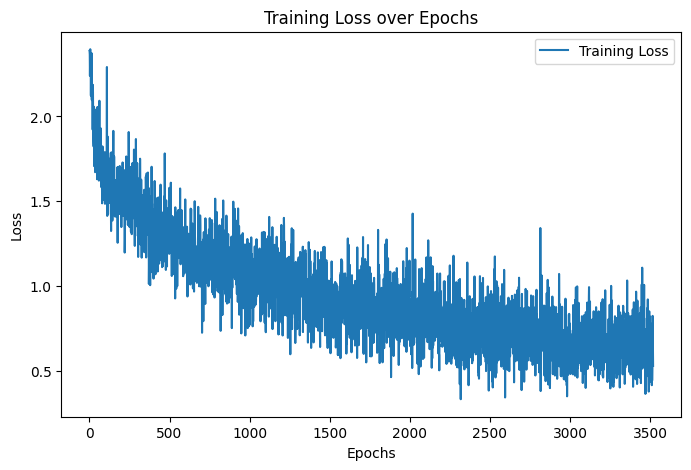

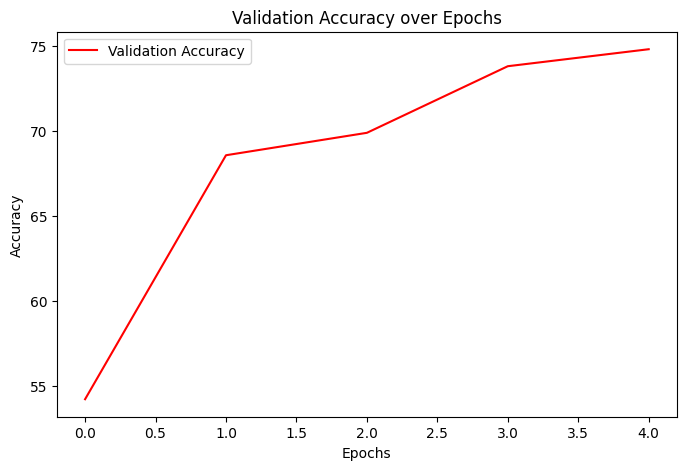

In [12]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(8, 5))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(8, 5))
plt.plot(accuracy_values, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

#This was when there was regularization